# Sequential Model

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from collections import ChainMap
from operator import itemgetter

In [3]:
import lightgbm as lgb
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
import pandas as pd
import scipy
import scipy.signal
from sklearn.cluster import KMeans
from sklearn.base import clone, BaseEstimator, TransformerMixin
from sklearn.externals import joblib
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import VarianceThreshold

In [4]:
from basedir import DATA, SAMPLE
from info import id_cols
from utils import to_feather, from_feather, starts, dropcols, float64, split

In [5]:
seed = 1
np.random.seed(seed)
rcParams['figure.figsize'] = 10, 8

In [82]:
x_trn, y_trn, x_tst = from_feather('x_trn', 'y_trn', 'x_tst')

/home/ck/anaconda3/envs/fastai_10/lib/python3.7/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


In [6]:
x_trn.head()

,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003386,0.33995,1.5064,-9.4128
2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008973,0.42684,1.0993,-10.0960
4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


# Plotting Data Samples

In [7]:
ids = x_trn.series_id.unique()

In [8]:
sample = np.random.choice(ids, 3)

In [9]:
subset = x_trn[x_trn.series_id.isin(sample)]

In [10]:
def series_plot(data, columns, normalize=True, figsize=(9, 14)):
    groups = data.groupby('series_id')
    f, axes = plt.subplots(len(groups), 1, figsize=figsize)
    f.subplots_adjust(hspace=0.5)
    for ax, (series_id, group) in zip(axes.flat, groups):
        group = group.copy()
        x = group.measurement_number.values
        group = group[columns]
        if normalize:
            group = StandardScaler().fit_transform(float64(group))
        df = pd.DataFrame(group, columns=columns)
        df['x'] = x
        df.plot(x='x', ax=ax)
        ax.legend(loc='center right', bbox_to_anchor=(1.25, 0.5))
        ax.set_title(f'Series ID = {series_id}')
        ax.set_xlabel('Measurement No.')

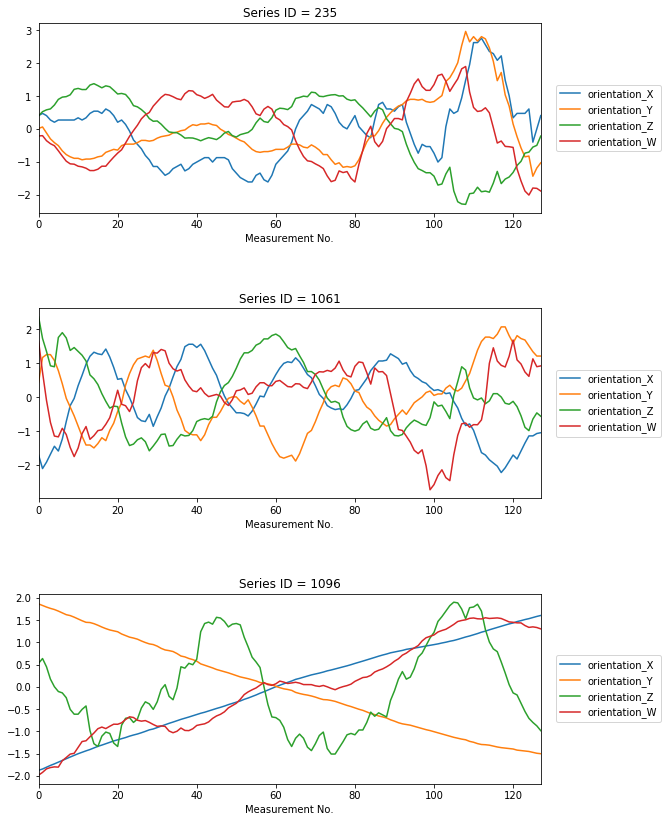

In [11]:
series_plot(subset, starts(x_trn, 'orient'))

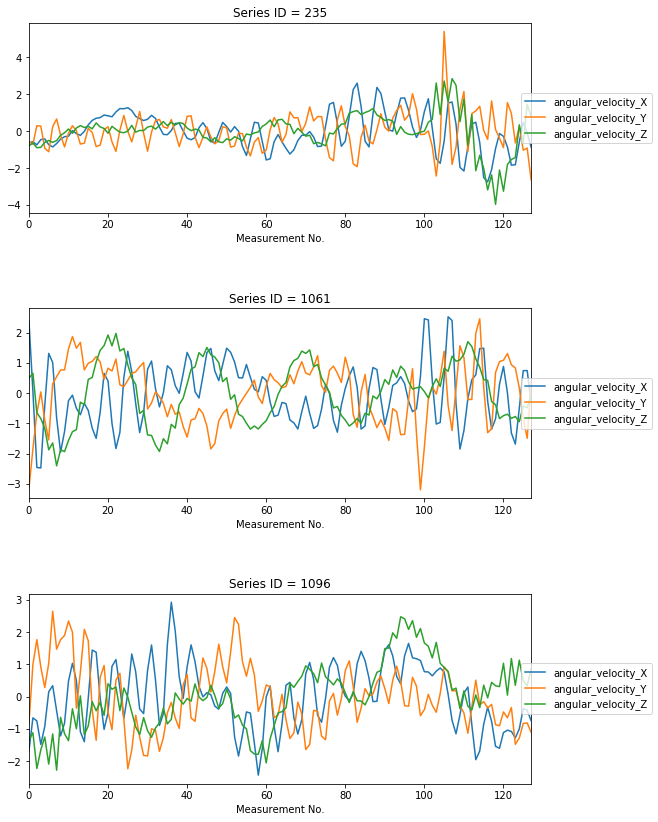

In [12]:
series_plot(subset, starts(x_trn, 'ang'))

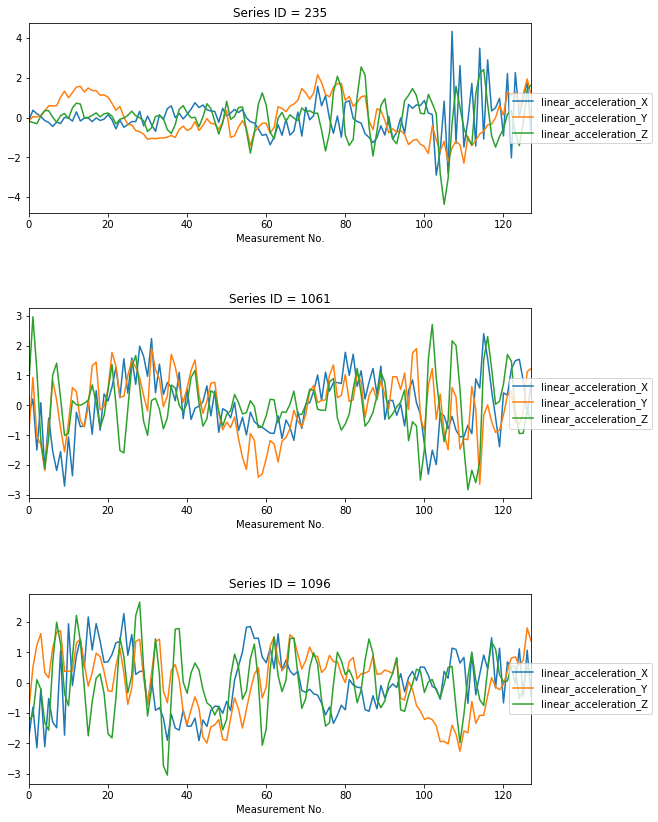

In [13]:
series_plot(subset, starts(x_trn, 'lin'))

# Naïve LightGBM

The simplest method to train a model is to "flatten" the original dataset into wide format for each series observation.

In [14]:
trn_ids, val_ids = train_test_split(ids, stratify=y_trn.surface, test_size=0.2, random_state=seed)

In [15]:
trn_df = x_trn[x_trn.series_id.isin(trn_ids)]
val_df = x_trn[x_trn.series_id.isin(val_ids)]

In [16]:
feat_cols = [col for col in trn_df.columns if col not in id_cols]

In [13]:
trn_vec = np.row_stack([
    group[feat_cols].T.values.flatten() 
    for _, group in trn_df.groupby('series_id')])

trn_target = y_trn.surface[y_trn.series_id.isin(trn_ids)]

val_vec = np.row_stack([
    group[feat_cols].T.values.flatten()
    for _, group in val_df.groupby('series_id')])

val_target = y_trn.surface[y_trn.series_id.isin(val_ids)]

In [45]:
model = lgb.LGBMClassifier(n_estimators=1000, 
                           learning_rate=0.1,
                           objective='multiclass',
                           num_class=9)

In [42]:
def accuracy(y_true, y_pred):
    breakpoint()
    y_hat = y_pred.reshape(9).argmax(axis=1)
    value = (y_true == y_hat).mean()
    return 'accuracy', value, True

In [46]:
model.fit(trn_vec, trn_target,
          eval_set=[(val_vec, val_target)],
          verbose=10, early_stopping_rounds=20)

Training until validation scores don't improve for 20 rounds.
[10]	valid_0's multi_logloss: 1.27761
[20]	valid_0's multi_logloss: 0.992293
[30]	valid_0's multi_logloss: 0.863
[40]	valid_0's multi_logloss: 0.794323
[50]	valid_0's multi_logloss: 0.747519
[60]	valid_0's multi_logloss: 0.725738
[70]	valid_0's multi_logloss: 0.720771
[80]	valid_0's multi_logloss: 0.716958
[90]	valid_0's multi_logloss: 0.72222
Early stopping, best iteration is:
[78]	valid_0's multi_logloss: 0.716062


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=1000, n_jobs=-1, num_class=9, num_leaves=31,
        objective='multiclass', random_state=None, reg_alpha=0.0,
        reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

In [51]:
preds = model.predict(val_vec)

In [52]:
cm = confusion_matrix(val_target, preds)

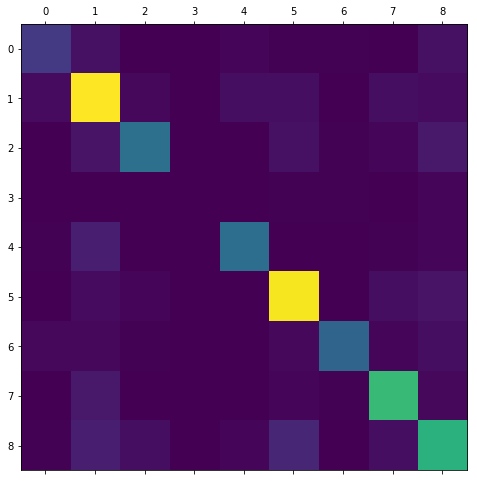

In [55]:
plt.matshow(cm)

In [38]:
tst_vec = np.row_stack([
    group[feat_cols].T.values.flatten() 
    for _, group in x_tst.groupby('series_id')])

In [39]:
preds = model.predict(tst_vec)

In [40]:
submit = pd.read_csv(SAMPLE)
submit['surface'] = preds
submit.to_csv('submit.csv', index=None)

In [41]:
!kaggle c submit career-con-2019 -f 'submit.csv' -m "Naive LightGBM with multi_logloss"

100%|██████████████████████████████████████| 52.4k/52.4k [00:00<00:00, 69.5kB/s]
Successfully submitted to CareerCon 2019 - Help Navigate Robots 

# Features Engineering

The code and ideas are mostly taken from [this post](http://ataspinar.com/2018/04/04/machine-learning-with-signal-processing-techniques/).

In [97]:
from detect_peaks import detect_peaks

In [7]:
def fft_values(y_values, T, N, f_s):
    f_values = np.linspace(0.0, 1.0/(2.0*T), N//2)
    fft_values_ = scipy.fft(y_values)
    fft_values_ = 2.0/N * np.abs(fft_values_[0:N//2])
    return f_values, fft_values_

In [8]:
def psd_values(y_values, T, N, f_s):
    return scipy.signal.welch(y_values, fs=f_s)

In [9]:
def autocorr_values(y_values, T, N, f_s):
    
    def autocorr(x):
        result = np.correlate(x, x, mode='full')
        return result[len(result)//2:]
    
    autocorr_values = autocorr(y_values)
    x_values = np.array([T*i for i in range(0, N)])
    return x_values, autocorr_values

In [10]:
ids = x_trn.series_id.unique()

In [ ]:
N = 128      # number of samples per experiment
f_s = 50     # signal frequency, Hz (?)
t_n = 2.56   # time frame (?)
T = t_n / N  # period 

In [ ]:
methods = ('fft', fft_values), ('psd', psd_values), ('autocorr', autocorr_values)

/home/ck/anaconda3/envs/fastai_10/lib/python3.7/site-packages/scipy/signal/spectral.py:1773: UserWarning: nperseg = 256 is greater than input length  = 128, using nperseg = 128
  .format(nperseg, input_length))


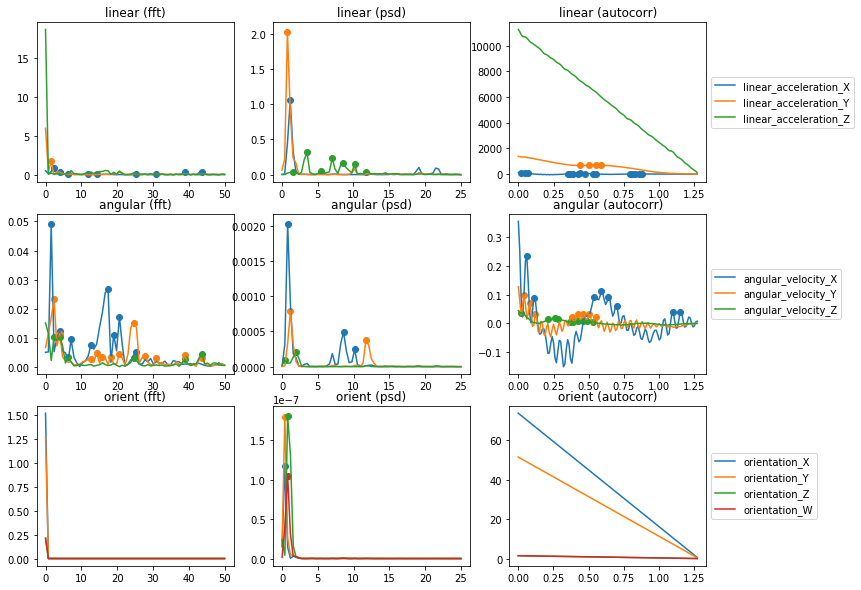

In [15]:
f, axes = plt.subplots(3, 3, figsize=(12, 10))
sample = x_trn[x_trn.series_id == 0]
subsets = 'linear', 'angular', 'orient'

for i, subset in enumerate(subsets):
    df = sample[starts(sample, subset)]
    values, columns = df.values, df.columns

    for j, (name, method) in enumerate(methods):
        ax = axes[i][j]
        ax.set_title(f'{subset} ({name})')
        for component, column in zip(values.T, columns):
            xs, ys = method(component, T, N, f_s)
            max_peak_height = 0.1*np.nanmax(ys)
            peaks = detect_peaks(ys, mph=max_peak_height)
            ax.plot(xs, ys, label=column)    
            ax.scatter(xs[peaks], ys[peaks])
        if j == 2:
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [71]:
def extract_features(data, extractors, T, N, f_s, denominator=10, perc=5):
    new_data = []
    for series_id, group in data.groupby('series_id'):
        new_feat = {'series_id': series_id}
        for _, feat in group.items():
            lo = np.nanpercentile(feat, perc)
            hi = np.nanpercentile(feat, 100 - perc)
            mph = lo + (hi - lo)/denominator
            extracted = dict(ChainMap(*[
                {f'{name}_{i}': x for i, x in enumerate(
                    peak_features(*ext(feat, T, N, f_s), mph))}
                for name, ext in extractors]))
            new_feat.update(extracted)
        new_data.append(new_feat)
    return pd.DataFrame(new_data)

In [95]:
def peak_features(xs, ys, mph):
    peaks = detect_peaks(ys, mph=mph)
    x_peaks, y_peaks = take_n_peaks(xs[peaks], ys[peaks])
    return x_peaks + y_peaks

In [96]:
def take_n_peaks(xs, ys, n_peaks=5):
    xs, ys = list(xs), list(ys)
    if len(xs) >= n_peaks:
        return xs[:n_peaks], ys[:n_peaks]
    else:
        n_missing = n_peaks - len(xs)
        return xs + [0]*n_missing, ys + [0]*n_missing

In [74]:
N = 128      # number of samples per experiment
f_s = 50     # signal frequency, Hz (?)
t_n = 2.56   # time frame (?)
T = t_n / N  # period 

In [91]:
trn_df = extract_features(x_trn, methods, T, N, f_s)

/home/ck/anaconda3/envs/fastai_10/lib/python3.7/site-packages/scipy/signal/spectral.py:1773: UserWarning: nperseg = 256 is greater than input length  = 128, using nperseg = 128
  .format(nperseg, input_length))


In [92]:
tst_df = extract_features(x_tst, methods, T, N, f_s)

In [93]:
# sanity check to exclude useless columns
thresh = VarianceThreshold(threshold=0.001)
selected = thresh.fit(trn_df).get_support()

In [94]:
trn_df = trn_df[trn_df.columns[selected]].copy()

In [95]:
tst_df = tst_df[trn_df.columns[selected]].copy()

In [96]:
to_feather(trn_df, 'trn_signal'), to_feather(tst_df, 'tst_signal')

(PosixPath('/home/ck/data/careercon2019/tmp/trn_signal.feather'),
 PosixPath('/home/ck/data/careercon2019/tmp/tst_signal.feather'))

# One More Model

In [13]:
trn_df, tst_df, y_trn = from_feather('trn_signal', 'tst_signal', 'y_trn')
x_trn = trn_df.drop(columns=['series_id'])
x_tst = tst_df.drop(columns=['series_id'])
surface = y_trn.surface
enc = LabelEncoder().fit(surface)
target = enc.transform(surface)

In [75]:
def accuracy(y_true, y_pred):
    n = len(y_true)
    y_hat = y_pred.reshape(9, n).argmax(axis=0)
    value = (y_true == y_hat).mean()
    return 'accuracy', value, True

In [56]:
test_result = np.zeros((len(x_tst), 9), dtype=np.float32)
for trn_idx, val_idx in split(trn_df, target):
    x_trn = trn_df[trn_df.index.isin(trn_idx)]
    x_val = trn_df[trn_df.index.isin(val_idx)]
    y_trn = target[trn_idx]
    y_val = target[val_idx]
    model = lgb.LGBMClassifier(
        n_estimators=1000, learning_rate=0.1,
        objective='multiclass', num_class=9)
    model.fit(x_trn, y_trn,
             eval_set=[(x_val, y_val)],
             eval_metric=accuracy,
             early_stopping_rounds=100,
             verbose=100)
    val_preds = model.predict_proba(x_val)
    acc = (y_val == val_preds.argmax(axis=1)).mean()
    print(f'Validation accuracy: {acc:2.2%}')
    test_result += model.predict_proba(tst_df)
test_result /= 5

Running 1 of 5 folds
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's multi_logloss: 1.26309	valid_0's accuracy: 0.543081
Early stopping, best iteration is:
[70]	valid_0's multi_logloss: 1.23509	valid_0's accuracy: 0.533943
Validation accuracy: 53.39%
Running 2 of 5 folds
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's multi_logloss: 1.35592	valid_0's accuracy: 0.526797
Early stopping, best iteration is:
[63]	valid_0's multi_logloss: 1.31957	valid_0's accuracy: 0.518954
Validation accuracy: 51.90%
Running 3 of 5 folds
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's multi_logloss: 1.25563	valid_0's accuracy: 0.549869
Early stopping, best iteration is:
[59]	valid_0's multi_logloss: 1.2197	valid_0's accuracy: 0.545932
Validation accuracy: 54.59%
Running 4 of 5 folds
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's multi_logloss: 1.29095	valid_0's accuracy: 0.544737
Ear

In [53]:
test = test_result.argmax(axis=1)

In [54]:
submit = pd.read_csv(SAMPLE)
submit['surface'] = enc.inverse_transform(test)
submit.to_csv('submit.csv', index=None)

In [55]:
!kaggle c submit career-con-2019 -f 'submit.csv' -m "LightGBM normalized"

100%|██████████████████████████████████████| 50.8k/50.8k [00:00<00:00, 43.0kB/s]
Successfully submitted to CareerCon 2019 - Help Navigate Robots 

# Another Approach To Derive Features

In [51]:
class LagFeatures:
    def __init__(self, mode='first', n=5):
        if mode not in {'first', 'middle', 'last'}:
            raise ValueError('unexpected mode')
        self.mode = mode
        self.n = n
    
    def __call__(self, data):
        if self.mode == 'first':
            start, end = 0, self.n
        elif self.mode == 'last':
            start, end = -self.n, len(data)
        elif self.mode == 'middle':
            mid = len(data) // 2
            div, mod = divmod(self.n, 2)
            start, end = mid-div, mid+div+mod
        cols = data.columns
        vec = data.iloc[start:end].values.T.ravel()
        new_cols = [f'{col}_{self.mode}{i}' for i in range(self.n) for col in cols]
        return dict(zip(new_cols, vec))

In [ ]:
def take_n_peaks(arr, n_peaks=5):
    arr = list(arr)
    if len(arr) >= n_peaks:
        return arr[:n_peaks]
    else:
        n_missing = n_peaks - len(arr)
        return arr + [0]*n_missing

In [134]:
class PeakFeatures:
    def __init__(self, window=4, perc=5, denom=10, n_peaks=5):
        self.window = window
        self.perc = perc
        self.denom = denom
        self.n_peaks = n_peaks
    
    def __call__(self, data):
        smoothed = data.rolling(window=self.window).mean()
        new_feat = {}
        for _, feat in smoothed.items():
            lo = np.nanpercentile(feat, self.perc)
            hi = np.nanpercentile(feat, 100 - self.perc)
            mph = lo + (hi - lo)/self.denom
            peaks = take_n_peaks(detect_peaks(feat, mph), self.n_peaks)
            new_feat.update({f'{feat.name}_peak{i}': p for i, p in enumerate(peaks)})
        return new_feat

In [135]:
_, group = next(iter(x_trn.groupby('series_id')))
group = group.drop(columns=['series_id', 'measurement_number'])

In [138]:
samplers = [
    LagFeatures('first'),
    LagFeatures('middle'),
    LagFeatures('last'),
    PeakFeatures()]

In [141]:
def generate_features(data, samplers, ignore=None):
    return pd.DataFrame([
        dict(ChainMap(*[
            sampler(group.drop(columns=ignore or [])) for sampler in samplers]))
        for series_id, group in data.groupby('series_id')])

In [142]:
ignore = ['series_id', 'measurement_number']
trn_df = generate_features(x_trn, samplers, ignore=ignore)
tst_df = generate_features(x_tst, samplers, ignore=ignore)

In [144]:
surface = y_trn.surface
enc = LabelEncoder().fit(surface)
target = enc.transform(surface)

In [145]:
test_result = np.zeros((len(tst_df), 9), dtype=np.float32)
for trn_idx, val_idx in split(trn_df, target):
    x_trn = trn_df[trn_df.index.isin(trn_idx)]
    x_val = trn_df[trn_df.index.isin(val_idx)]
    y_trn = target[trn_idx]
    y_val = target[val_idx]
    model = lgb.LGBMClassifier(
        n_estimators=1000, learning_rate=0.01,
        objective='multiclass', num_class=9)
    model.fit(x_trn, y_trn,
             eval_set=[(x_val, y_val)],
             eval_metric=accuracy,
             early_stopping_rounds=100,
             verbose=100)
    val_preds = model.predict_proba(x_val)
    acc = (y_val == val_preds.argmax(axis=1)).mean()
    print(f'Validation accuracy: {acc:2.2%}')
    test_result += model.predict_proba(tst_df)
test_result /= 5

Running 1 of 5 folds
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's multi_logloss: 0.603633	valid_0's accuracy: 0.781984
Early stopping, best iteration is:
[98]	valid_0's multi_logloss: 0.601592	valid_0's accuracy: 0.780679
Validation accuracy: 78.07%
Running 2 of 5 folds
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's multi_logloss: 0.667597	valid_0's accuracy: 0.776471
Early stopping, best iteration is:
[88]	valid_0's multi_logloss: 0.663446	valid_0's accuracy: 0.773856
Validation accuracy: 77.39%
Running 3 of 5 folds
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's multi_logloss: 0.608861	valid_0's accuracy: 0.800525
Early stopping, best iteration is:
[86]	valid_0's multi_logloss: 0.605147	valid_0's accuracy: 0.793963
Validation accuracy: 79.40%
Running 4 of 5 folds
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's multi_logloss: 0.615156	valid_0's accuracy: 0.78

In [146]:
test = test_result.argmax(axis=1)
submit = pd.read_csv(SAMPLE)
submit['surface'] = enc.inverse_transform(test)
submit.to_csv('submit.csv', index=None)
!kaggle c submit career-con-2019 -f 'submit.csv' -m "LightGBM more features"

100%|██████████████████████████████████████| 52.4k/52.4k [00:00<00:00, 48.5kB/s]
Successfully submitted to CareerCon 2019 - Help Navigate Robots 